In [ ]:
 #install packages
!pip install transformers
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import random

import logging
import random
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support


def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    classes, counts = np.unique(y, return_counts=True)
    if test_size == 0:
        return X, [], y, []
    # Find classes with only one or two instances
    small_classes = classes[counts < 5]

    # Separate out the instances of small classes
    large_class_mask = ~np.isin(y, small_classes)
    X_large = X[large_class_mask]
    y_large = y[large_class_mask]
    X_small = X[~large_class_mask]
    y_small = y[~large_class_mask]

    # Perform stratified split on the larger classes dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_large, y_large, test_size=test_size, random_state=random_state, stratify=y_large
    )

    # Randomly assign instances of small classes to training or testing sets
    for i in range(len(X_small)):
        if np.random.rand() < test_size:
            X_test = np.vstack([X_test, X_small[i]])
            y_test = np.hstack([y_test, y_small[i]])
        else:
            X_train = np.vstack([X_train, X_small[i]])
            y_train = np.hstack([y_train, y_small[i]])

    return X_train, X_test, y_train, y_test

#evaluation
def accuracy_per_class(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()

    accuracy_dict = {}
    count_dict = {}

    for label in np.unique(labels_flat):
        y_preds = pred_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy_dict[label] = np.sum(y_preds == y_true) / len(y_true) if len(y_true) > 0 else 0
        count_dict[label] = len(y_true)

    return accuracy_dict, count_dict

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


# Function to calculate precision, recall, and F1 for each label
def calculate_metrics(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()
    
    # Calculate precision, recall, and F1 score per label
    precision, recall, f1, _ = precision_recall_fscore_support(labels_flat, pred_flat, average=None, labels=np.unique(labels_flat))
    
    return precision, recall, f1
    

# Configure logging
logging.basicConfig(filename='smm4h_top6_training_40ep_16bs_5e-5lr_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

class TQDMLoggingWrapper(tqdm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logger = logger

    def display(self, msg=None, pos=None):
        if msg is not None:
            self.logger.info(msg)
        super().display(msg, pos)

    def update(self, n=1):
        super().update(n)
        desc = self.format_dict.get('desc', 'No description')
        postfix = self.format_dict.get('postfix', '')
        self.logger.info(f'{desc} - {postfix}')

    def set_description(self, desc=None, refresh=True):
        super().set_description(desc, refresh)
        if desc:
            self.logger.info(f'Set description: {desc}')


# Function to evaluate the model
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

#Read data from git:
#https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Data/CADEC/3.csv
# URL of the CSV file
cadec_csv_url = "https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Data/CADEC/3.csv"
# read data from smm4h
smm4h_csv_url = "https://raw.githubusercontent.com/FANMISUA/ADE_Norm/main/Data/smm4h_soc.tsv"

top6SMM4H = [10037175, 10018065,10029205, 10017947, 10028395, 10022891]
top6label_dict = {
    10037175: 0,
    10018065: 1,
    10029205: 2,
    10017947: 3,
    10028395: 4,
    10022891: 5
}


# Read the CSV file into a pandas DataFrame
column_names = ["ade", "soc_code"]
smm4h_all = pd.read_csv(smm4h_csv_url,names=column_names, sep = '\t', header=None)

smm4h_all = smm4h_all[smm4h_all['soc_code'] != 0]
smm4h_all['soc_code'] = pd.to_numeric(smm4h_all['soc_code'], errors='coerce').astype('Int64')
smm4h_unique = smm4h_all.drop_duplicates(subset='ade')

# print("smm4h data:",smm4h_all.shape)
smm4h_soc_code_counts = smm4h_unique['soc_code'].value_counts()
# Sort the counts from high to low and print the result
print("SOC count in CADEC: ",smm4h_soc_code_counts)
# Filter DataFrame
smm4h_filtered_data3 = smm4h_unique[smm4h_unique['soc_code'].isin(top6SMM4H)]
# filtered_data6 = cadec_unique[cadec_unique['soc_code'].isin(top6SMM4H)]

# Select only the Term and SOC columns
top6inSMM4H = smm4h_filtered_data3[['ade', 'soc_code']]
# CADECtop6inSMM4H = filtered_data6[['ade', 'soc_code']]

# Read the CSV file into a pandas DataFrame
column_names = ["TT", "llt_code", "ade", "soc_code"]
cadec_all = pd.read_csv(cadec_csv_url,names=column_names, header=None)

# Remove duplicate rows based on the 'ade' column
cadec_unique = cadec_all.drop_duplicates(subset='ade')

# Display the resulting DataFrame
# print("clean cadec data:",cadec_unique.shape)
# Count occurrences of each 'soc_code'
cadec_soc_code_counts = cadec_unique['soc_code'].value_counts()
# Sort the counts from high to low and print the result
# print("SOC count in CADEC: ",cadec_soc_code_counts)


# Filter DataFrame
cadec_filtered_data3 = cadec_unique[cadec_unique['soc_code'].isin(top6SMM4H)]
# filtered_data6 = cadec_unique[cadec_unique['soc_code'].isin(top6SMM4H)]

# Select only the Term and SOC columns
CADECtop6inSMM4H = cadec_filtered_data3[['ade', 'soc_code']]
# CADECtop6inSMM4H = filtered_data6[['ade', 'soc_code']]


# For SMM4H data
df1 = top6inSMM4H.copy()
df1.loc[:, 'label'] = df1['soc_code'].map(top6label_dict)

# For CADEC data
df2 = CADECtop6inSMM4H.copy()
df2.loc[:, 'label'] = df2['soc_code'].map(top6label_dict)

print("SMM4H top 6",df1)
print("CADEC top 6",df2)

#smm4h top6 data
df = df1

# Define the random seeds and other parameters
seed_values = list(range(2, 42, 2))
batch_size = 16
epochs = 40
learningrate = 5e-5

# Placeholder for accuracies
all_accuracies = {label: [] for label in range(len(top6label_dict))}

# Initialize dictionaries to hold metrics for each seed
seed_metrics = {seed_val: {'precision': [], 'recall': [], 'f1': []} for seed_val in seed_values}


# Main loop over seed values
for seed_val in seed_values:
    # Set seeds
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Data preparation
    X_train, X_val, y_train, y_val = custom_train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=seed_val)
    df['data_type'] = ['not_set'] * df.shape[0]
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'
    # logger.info(df.groupby(['soc_code', 'label', 'data_type']).count())

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    encoded_data_train = tokenizer.batch_encode_plus(
        df[df.data_type == 'train'].ade.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    encoded_data_val = tokenizer.batch_encode_plus(
        df[df.data_type == 'val'].ade.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(top6label_dict), output_attentions=False, output_hidden_states=False)

    dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
    dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learningrate, eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train) * epochs)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger.info(f"Device used: {device}")

    # Training loop
    for epoch in TQDMLoggingWrapper(range(1, epochs+1), desc='Epoch Progress'):
        model.train()
        loss_train_total = 0

        progress_bar = TQDMLoggingWrapper(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

            outputs = model(**inputs)
            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'training_loss': f'{loss.item()/len(batch):.3f}'})

        # torch.save(model.state_dict(), f'./ADENorm_top3_epoch_{epoch}.model')

        logger.info(f'\nEpoch {epoch}')
        loss_train_avg = loss_train_total / len(dataloader_train)
        logger.info(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    precision, recall, f1, _ = precision_recall_fscore_support(true_vals.flatten(), np.argmax(predictions, axis=1).flatten(), average=None, labels=np.unique(true_vals.flatten()))

    for label in np.unique(true_vals):
        seed_metrics[seed_val]['precision'].append((label, precision[label]))
        seed_metrics[seed_val]['recall'].append((label, recall[label]))
        seed_metrics[seed_val]['f1'].append((label, f1[label]))

# Write the precision, recall, F1 scores, and seed values to a file
with open('SMM4H_top6_20times_results_with_seeds.txt', 'w') as f:
    f.write('Seed\tLabel\tPrecision\tRecall\tF1\n')
    for seed_val in seed_values:
        for label, precision_val in seed_metrics[seed_val]['precision']:
            recall_val = next(val for lbl, val in seed_metrics[seed_val]['recall'] if lbl == label)
            f1_val = next(val for lbl, val in seed_metrics[seed_val]['f1'] if lbl == label)
            f.write(f'{seed_val}\t{label}\t{precision_val:.4f}\t{recall_val:.4f}\t{f1_val:.4f}\n')

# Initialize lists for storing the mean and standard deviation
mean_precision = []
std_precision = []
mean_recall = []
std_recall = []
mean_f1 = []
std_f1 = []

# Extract unique labels
unique_labels = np.unique(true_vals.flatten())

for label in unique_labels:
    # Collect precision, recall, and f1 scores for each label across all seeds
    precisions = [val for lbl, val in seed_metrics[seed_val]['precision'] if lbl == label]
    recalls = [val for lbl, val in seed_metrics[seed_val]['recall'] if lbl == label]
    f1s = [val for lbl, val in seed_metrics[seed_val]['f1'] if lbl == label]

    # Calculate mean and standard deviation
    mean_precision.append(np.mean(precisions))
    std_precision.append(np.std(precisions))
    mean_recall.append(np.mean(recalls))
    std_recall.append(np.std(recalls))
    mean_f1.append(np.mean(f1s))
    std_f1.append(np.std(f1s))

# Convert lists to numpy arrays for easier plotting
mean_precision = np.array(mean_precision)
std_precision = np.array(std_precision)
mean_recall = np.array(mean_recall)
std_recall = np.array(std_recall)
mean_f1 = np.array(mean_f1)
std_f1 = np.array(std_f1)

# Plotting
x = np.arange(len(unique_labels))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, mean_precision, width, yerr=std_precision, capsize=5, label='Precision', color='blue', alpha=0.7)
rects2 = ax.bar(x, mean_recall, width, yerr=std_recall, capsize=5, label='Recall', color='green', alpha=0.7)
rects3 = ax.bar(x + width, mean_f1, width, yerr=std_f1, capsize=5, label='F1 Score', color='red', alpha=0.7)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Labels')
ax.set_ylabel('Scores')
ax.set_title('Mean and Standard Deviation of Precision, Recall, and F1 Scores by Label')
ax.set_xticks(x)
ax.set_xticklabels(unique_labels)
ax.legend()

# Save and show the plot
plt.tight_layout()
plt.savefig('SMM4H_top6_20times_results_plot.png')
plt.show()


SOC count in CADEC:  soc_code
10037175    287
10018065    235
10029205    212
10017947     63
10028395     58
10022891     54
10027433     48
10040785     28
10038738     22
10022117     16
10015919     16
10038604     10
10047065     10
10021428      8
10041244      7
10007541      7
10038359      6
10021881      5
10013993      4
10019805      2
10042613      2
10029104      2
10077536      1
10010331      1
0             1
10014698      1
Name: count, dtype: Int64
SMM4H top 6                             ade  soc_code  label
3                            AD  10037175      0
4                         focus  10029205      2
5                          died  10018065      1
8                        dreams  10037175      0
10                   withdrawal  10018065      1
...                         ...       ...    ...
1698     can't go back to sleep  10037175      0
1703                 chest hurt  10018065      1
1704   got ten minutes of sleep  10037175      0
1708  never have another o

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\fd\anaconda3\envs\torch\Lib\site-packages\transformers\tokenization_utils_base.py:2888: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a

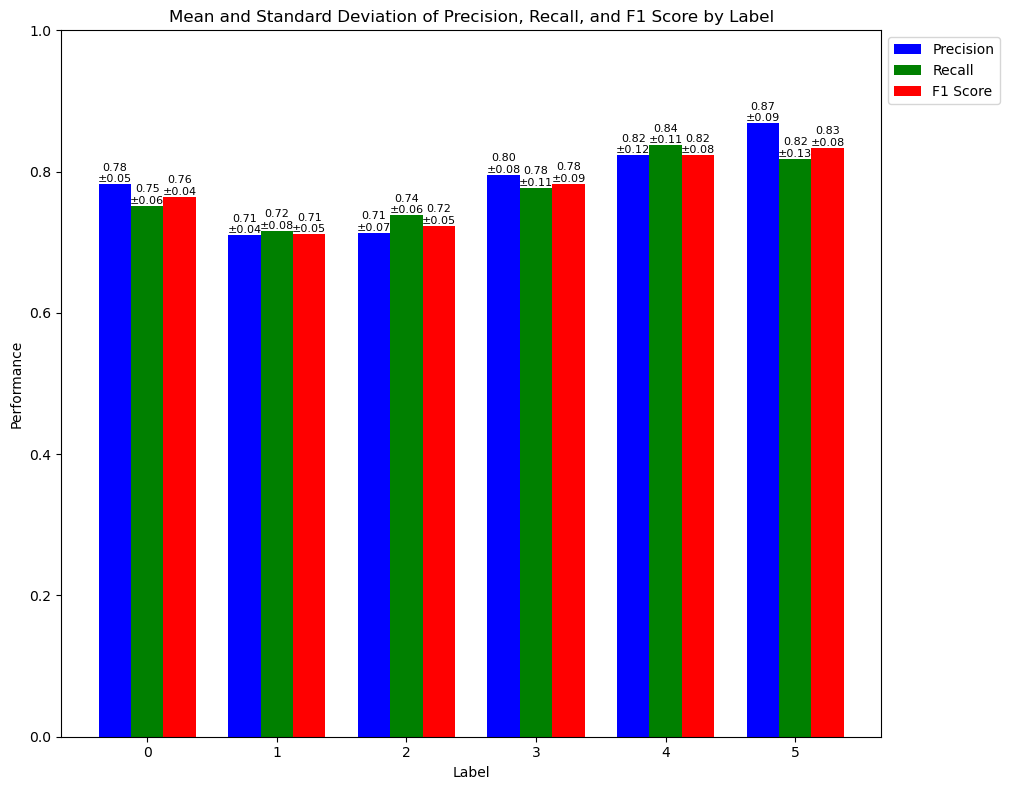

In [9]:
# Initialize lists to hold precision, recall, and f1 values for each label
precision_dict, recall_dict, f1_dict = {}, {}, {}

# Collect metrics across seeds
for seed in seed_metrics:
    for label, value in seed_metrics[seed]['precision']:
        precision_dict.setdefault(label, []).append(value)
    for label, value in seed_metrics[seed]['recall']:
        recall_dict.setdefault(label, []).append(value)
    for label, value in seed_metrics[seed]['f1']:
        f1_dict.setdefault(label, []).append(value)

# Compute mean and std for precision, recall, and f1
labels = sorted(precision_dict.keys())
precision_mean = [np.mean(precision_dict[label]) for label in labels]
precision_std = [np.std(precision_dict[label]) for label in labels]
recall_mean = [np.mean(recall_dict[label]) for label in labels]
recall_std = [np.std(recall_dict[label]) for label in labels]
f1_mean = [np.mean(f1_dict[label]) for label in labels]
f1_std = [np.std(f1_dict[label]) for label in labels]

# Plotting
x = np.arange(len(labels))  # label indices
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bar plots with mean values
bars_precision = ax.bar(x - width, precision_mean, width, label='Precision', color='b')
bars_recall = ax.bar(x, recall_mean, width, label='Recall', color='g')
bars_f1 = ax.bar(x + width, f1_mean, width, label='F1 Score', color='r')

# Annotate bars with mean and std values
# Annotate bars with mean and std values, with smaller font size
for bars, means, stds in zip([bars_precision, bars_recall, bars_f1],
                             [precision_mean, recall_mean, f1_mean],
                             [precision_std, recall_std, f1_std]):
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{mean:.2f}\n±{std:.2f}', ha='center', va='bottom', fontsize=8)  # Smaller font size


# Labels and title
ax.set_xlabel('Label')
ax.set_ylabel('Performance')
ax.set_title('Mean and Standard Deviation of Precision, Recall, and F1 Score by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Set y-axis limit to [0, 1]
ax.set_ylim(0, 1)

# Move legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the plot to fit the legend
plt.show()
